# INFO 254 Final Project: H1B Case Prediction

### Goal

This is a binary classification problem. Our goal is to predict whether a new H1B case is going to be certified or denied. The outcome variable is binary, either 0 denied or 1 certified. 

### Team Members

Yin Qiu, Chuhan Wang, Yuexi Wang

# Section 1: Data Preprocessing



1. import libraries and load data

2. truncate the data

since we have over three million observations, we plan to narrow it down to only those observations between the year 2014 to 2016

3. missing data

we can explore where the missing data are and how much percentage of missing values are in each feature. If missing data are less than 10%, we can drop the nulls. If the missing data are of higher share, we may replace it with mean/ median/ mode.


## Import Libaries and Load Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/254 DMA/DMA Final Project

/content/drive/MyDrive/254 DMA/DMA Final Project


In [3]:
# %cd /content/drive/MyDrive/DMA Final Project
##ignore this don't run this 

In [4]:
import numpy as np
import matplotlib
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [5]:
df = pd.read_csv('h1b_kaggle.csv')
df.drop('Unnamed: 0',inplace=True ,axis=1)
df.head(5)

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
0,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016.0,"ANN ARBOR, MICHIGAN",-83.743038,42.280826
1,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,242674.0,2016.0,"PLANO, TEXAS",-96.698886,33.019843
2,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,193066.0,2016.0,"JERSEY CITY, NEW JERSEY",-74.077642,40.728158
3,CERTIFIED-WITHDRAWN,"GATES CORPORATION, A WHOLLY-OWNED SUBSIDIARY O...",CHIEF EXECUTIVES,"REGIONAL PRESIDEN, AMERICAS",Y,220314.0,2016.0,"DENVER, COLORADO",-104.990251,39.739236
4,WITHDRAWN,PEABODY INVESTMENTS CORP.,CHIEF EXECUTIVES,PRESIDENT MONGOLIA AND INDIA,Y,157518.4,2016.0,"ST. LOUIS, MISSOURI",-90.199404,38.627003


## Truncating the Data

In [6]:
# truncating the data to only keep entries from 2014-2016
df= df.loc[df['YEAR'].isin(['2016.0','2015.0','2014.0'])]
df.shape

(1785957, 10)

After the truncating now we have about 1.7 million entries

## Missing Data

In [7]:
# missing data
df.isnull().sum()

CASE_STATUS               0
EMPLOYER_NAME            29
SOC_NAME               4279
JOB_TITLE                14
FULL_TIME_POSITION        1
PREVAILING_WAGE          22
YEAR                      0
WORKSITE                  0
lon                   54282
lat                   54282
dtype: int64

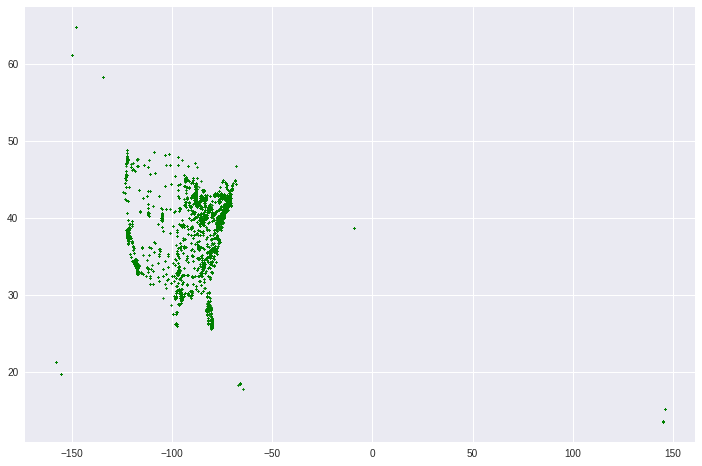

In [8]:
# plot the data in lon and lat and see the geographic focus

plt.figure(1, figsize=[12,8])
ax = plt.scatter(x=df['lon'], y=df['lat'], color='g', alpha=.8, edgecolor='g', s=.9)
plt.show()

It seems some lon-lat locations are suspiciously outside of US, so they are not matching with the worksites which should be within the US.

In [9]:
# check the worksite of missin lon-lat locations, and they are actually within the US
df[df['lon'].isnull()].head(20)

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
8,CERTIFIED-WITHDRAWN,ESI COMPANIES INC.,CHIEF EXECUTIVES,PRESIDENT,Y,127546.0,2016.0,"MEMPHIS, TEXAS",NaN,NaN
12,CERTIFIED-WITHDRAWN,ACUSHNET COMPANY,CHIEF EXECUTIVES,TREASURER AND COO,Y,203860.8,2016.0,"FAIRHAVEN, MASSACHUSETTS",NaN,NaN
45,CERTIFIED,THE CHICAGO ATHENAEUM: CENTER FOR ARCHITECTURE...,CHIEF EXECUTIVES,EXECUTIVE DIRECTOR,N,54766.0,2016.0,"GALENA, ILLINOIS",NaN,NaN
54,CERTIFIED,VARIANTYX INC.,CHIEF EXECUTIVES,CHIEF INFORMATION OFFICER,Y,164403.0,2016.0,"ASHLAND, MASSACHUSETTS",NaN,NaN
55,CERTIFIED,NATURAL AMERICAN FOODS INC.,CHIEF EXECUTIVES,VICE PRESIDENT OF QUALITY,Y,145829.0,2016.0,"ONSTED, MICHIGAN",NaN,NaN
57,CERTIFIED,NATURAL AMERICAN FOODS INC.,CHIEF EXECUTIVES,VICE PRESIDENT OF QUALITY,Y,145829.0,2016.0,"ONSTED, MICHIGAN",NaN,NaN
91,DENIED,EAGLE MINE LLC,CHIEF EXECUTIVES,GENERAL MANAGER,Y,116334.0,2016.0,"CHAMPION, MICHIGAN",NaN,NaN
92,CERTIFIED,EAGLE MINE LLC,CHIEF EXECUTIVES,GENERAL MANAGER,Y,116334.0,2016.0,"CHAMPION, MICHIGAN",NaN,NaN
99,CERTIFIED,"BON WORTH, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,125424.0,2016.0,"HENDERSONVILLE, NORTH CAROLINA",NaN,NaN
108,CERTIFIED,"AMERICAN REFINING GROUP, INC.",CHIEF EXECUTIVES,SENIOR VICE PRESIDENT OF OPERATIONS,Y,202738.0,2016.0,"BRADFORD, PENNSYLVANIA",NaN,NaN


Taking a look at the entries of missing lon-lat, some of them are quite suspicious. For example, index 91 and 92 have the same features but different labels. We suspect the data quality is not good for these subset of data. Since they are not a big share of the whole dataset, we can simply drop these rows.

In [10]:
# drop na in columns lon, lat
df.dropna(subset=['lon', 'lat'], inplace=True)
# also drop lon lat since worksite seems to be more reliable
df.drop(['lon', 'lat'], axis=1, inplace=True)

In [11]:
df.isnull().sum()

CASE_STATUS              0
EMPLOYER_NAME           24
SOC_NAME              4182
JOB_TITLE               13
FULL_TIME_POSITION       1
PREVAILING_WAGE         19
YEAR                     0
WORKSITE                 0
dtype: int64

Because the missing value in other columns are very minimum compared to the whole size of dataset, we can drop all rows with nulls.


In [12]:
df.dropna(subset=['EMPLOYER_NAME', 'SOC_NAME', 'JOB_TITLE', 'FULL_TIME_POSITION', 'PREVAILING_WAGE'],
          inplace=True)
df.isnull().sum()

CASE_STATUS           0
EMPLOYER_NAME         0
SOC_NAME              0
JOB_TITLE             0
FULL_TIME_POSITION    0
PREVAILING_WAGE       0
YEAR                  0
WORKSITE              0
dtype: int64

In [13]:
df.shape

(1727446, 8)

In [14]:
df.head(10)

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE
0,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016.0,"ANN ARBOR, MICHIGAN"
1,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,242674.0,2016.0,"PLANO, TEXAS"
2,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,193066.0,2016.0,"JERSEY CITY, NEW JERSEY"
3,CERTIFIED-WITHDRAWN,"GATES CORPORATION, A WHOLLY-OWNED SUBSIDIARY O...",CHIEF EXECUTIVES,"REGIONAL PRESIDEN, AMERICAS",Y,220314.0,2016.0,"DENVER, COLORADO"
4,WITHDRAWN,PEABODY INVESTMENTS CORP.,CHIEF EXECUTIVES,PRESIDENT MONGOLIA AND INDIA,Y,157518.4,2016.0,"ST. LOUIS, MISSOURI"
5,CERTIFIED-WITHDRAWN,BURGER KING CORPORATION,CHIEF EXECUTIVES,"EXECUTIVE V P, GLOBAL DEVELOPMENT AND PRESIDEN...",Y,225000.0,2016.0,"MIAMI, FLORIDA"
6,CERTIFIED-WITHDRAWN,BT AND MK ENERGY AND COMMODITIES,CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,91021.0,2016.0,"HOUSTON, TEXAS"
7,CERTIFIED-WITHDRAWN,"GLOBO MOBILE TECHNOLOGIES, INC.",CHIEF EXECUTIVES,CHIEF OPERATIONS OFFICER,Y,150000.0,2016.0,"SAN JOSE, CALIFORNIA"
9,WITHDRAWN,LESSARD INTERNATIONAL LLC,CHIEF EXECUTIVES,PRESIDENT,Y,154648.0,2016.0,"VIENNA, VIRGINIA"
10,CERTIFIED-WITHDRAWN,H.J. HEINZ COMPANY,CHIEF EXECUTIVES,"CHIEF INFORMATION OFFICER, HEINZ NORTH AMERICA",Y,182978.0,2016.0,"PITTSBURGH, PENNSYLVANIA"


In [15]:
df.reset_index(drop=True, inplace=True)

# Section 2: Data Exploration and Feature Engineering

1. Exploratory Data Analysis (EDA)

2. clean data, drop outliers, create new feature, encode categorical data etc.

3. train test split

4. oversample imbalanced data in training




## Exploratory Data Analysis (EDA)

Overview: 

In addition to the exploration we did above, we also used the ggpairs function in r to examine the distribution and correlation between each pair of variables(unfortunately we could not include categorical columns ("SOC_NAME","JOB_TITLE","WORK_SITE","EMPLOYER_NAME") because they have over 15 categories.)

The graph is attached below. We can see that none of the numberical columns exhibit strong correlation. 

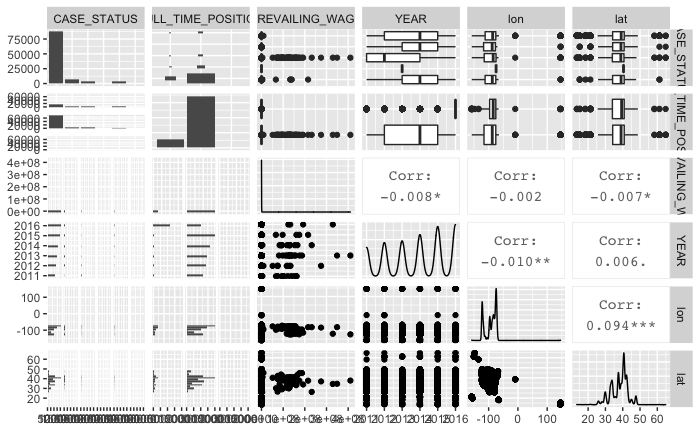

check the distribution of the wage of those who get rejected and certified, it seems like most annual wages are around 50k to 10k




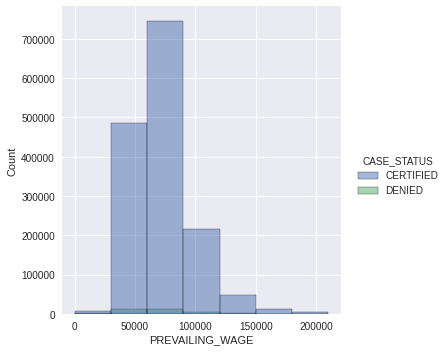

In [16]:
# Wage Distributions for Certified vs Denied Cases
df_wages = df[df['CASE_STATUS'].isin(['CERTIFIED', 'DENIED'])]
sns.displot(df_wages.query('PREVAILING_WAGE < 200000'), 
            x='PREVAILING_WAGE', hue='CASE_STATUS', binwidth=30000)

we need to zoom in to see the distributions separately, since the size of denied cases are so small.

In [17]:
df_certified_wage = df[df["CASE_STATUS"] == "CERTIFIED"]["PREVAILING_WAGE"]
wage = df_certified_wage[df_certified_wage < 200000]
wage_median = df_certified_wage.median()

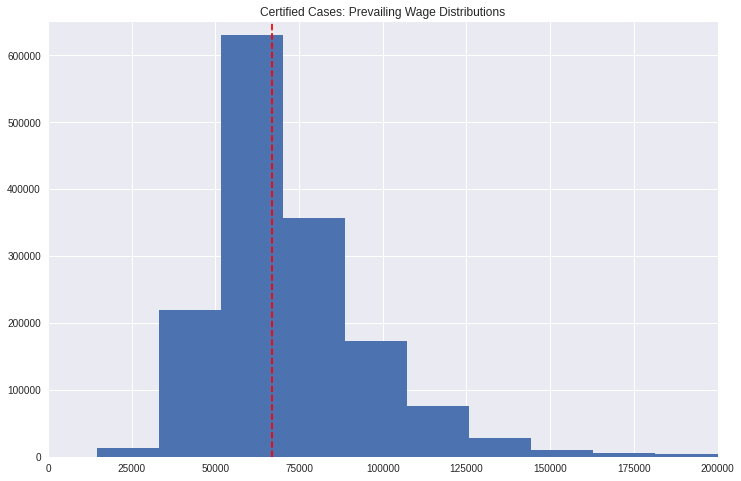

In [18]:
# Certified Cases: Prevailing Wage Distributions
plt.figure(figsize=[12,8])
plt.xlim(0, 200000)
plt.ylim(0, 650000)
plt.title('Certified Cases: Prevailing Wage Distributions')
plt.hist(np.asarray(wage))
plt.axvline(wage_median, color='red',label='Median', linestyle='--')

In [19]:
df_rejected_wage = df[df["CASE_STATUS"] == "DENIED"]["PREVAILING_WAGE"]
wage1 = df_rejected_wage[df_rejected_wage < 200000]
wage_median2 = df_rejected_wage.median()

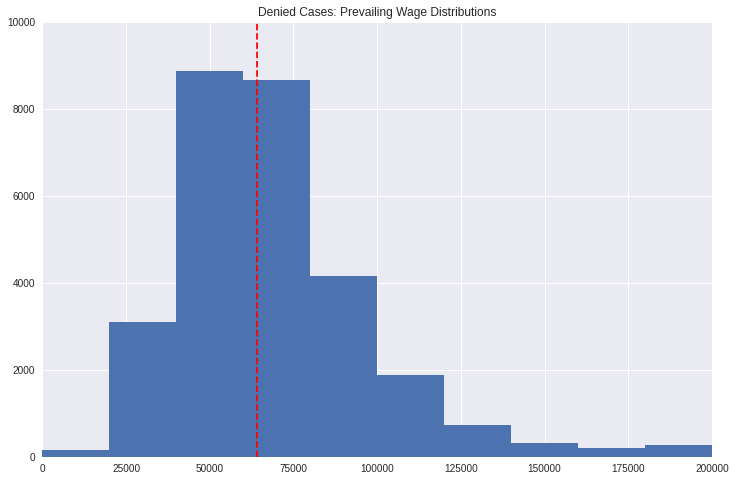

In [20]:
# Denied Cases: Prevailing Wage Distributions
plt.figure(figsize=[12,8])
plt.xlim(0, 200000)
plt.ylim(0, 10000)
plt.title('Denied Cases: Prevailing Wage Distributions')
plt.hist(np.asarray(wage1))
plt.axvline(wage_median2, color='red',label='Median', linestyle='--')

we can tell that the number of applications for H1B has increased over the years.



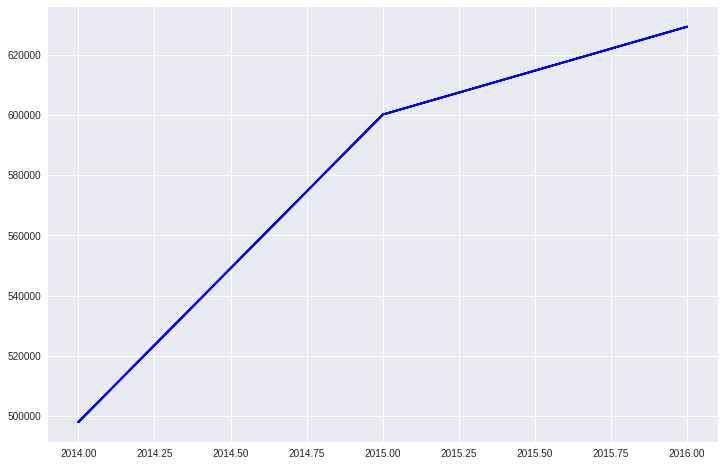

In [21]:
plt.figure(figsize=[12,8])
df['YEAR'] = df['YEAR'].apply(lambda x: int(x)) # change data type from float to integer
year_count = df.groupby('YEAR').count()
plt.plot(year_count, color='b')

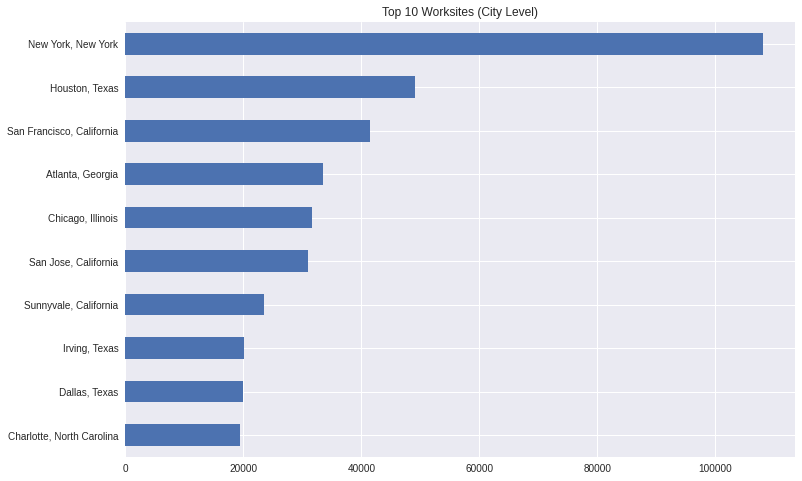

In [22]:
# city level top 10 worksites
plt.figure(figsize=[12,8])
plt.title('Top 10 Worksites (City Level)')
df['WORKSITE'] = df['WORKSITE'].apply(lambda x : x.title()) # clean up duplicates with different cases
df['WORKSITE'].value_counts()[:10].sort_values().plot(kind='barh')

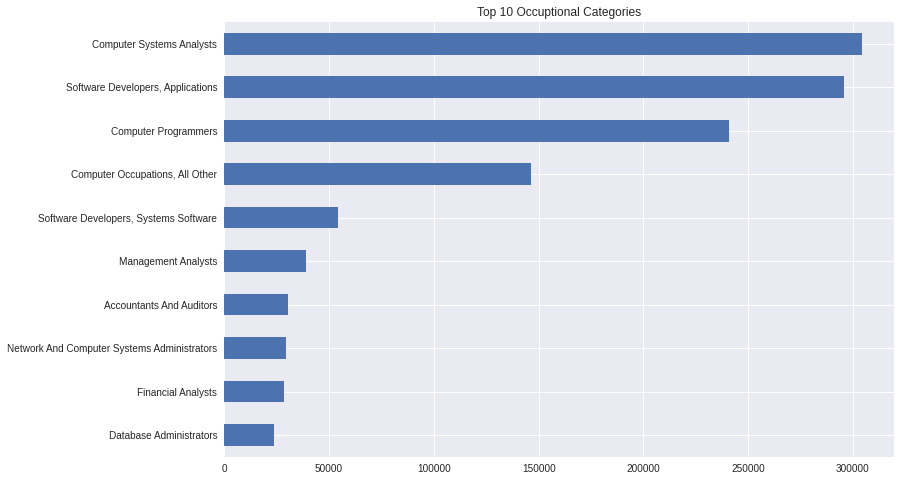

In [23]:
# top 10 occuptional categories
plt.figure(figsize=[12,8])
plt.title('Top 10 Occuptional Categories')
df['SOC_NAME']= df['SOC_NAME'].apply(lambda x : x.title()) # clean up the duplicates with different cases
df['SOC_NAME'].value_counts()[:10].sort_values().plot(kind='barh')

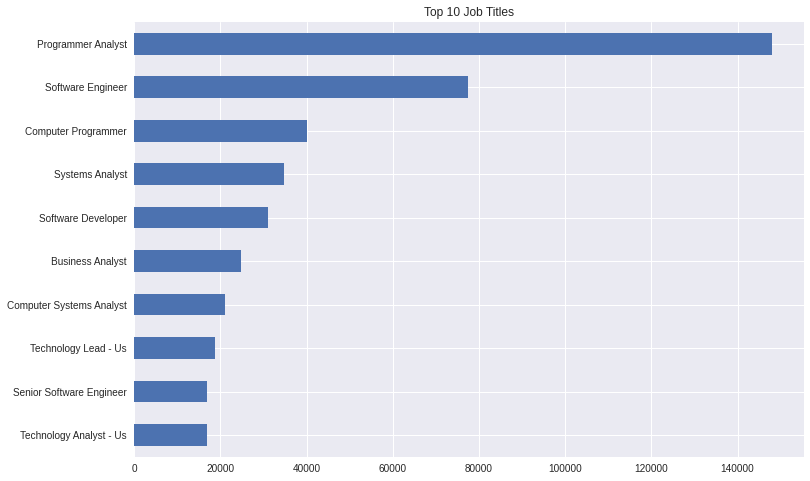

In [24]:
# top 10 job titles
plt.figure(figsize=[12,8])
plt.title('Top 10 Job Titles')
df['JOB_TITLE']= df['JOB_TITLE'].apply(lambda x : x.title()) # clean up duplicates with different cases
df['JOB_TITLE'].value_counts()[:10].sort_values().plot(kind='barh')

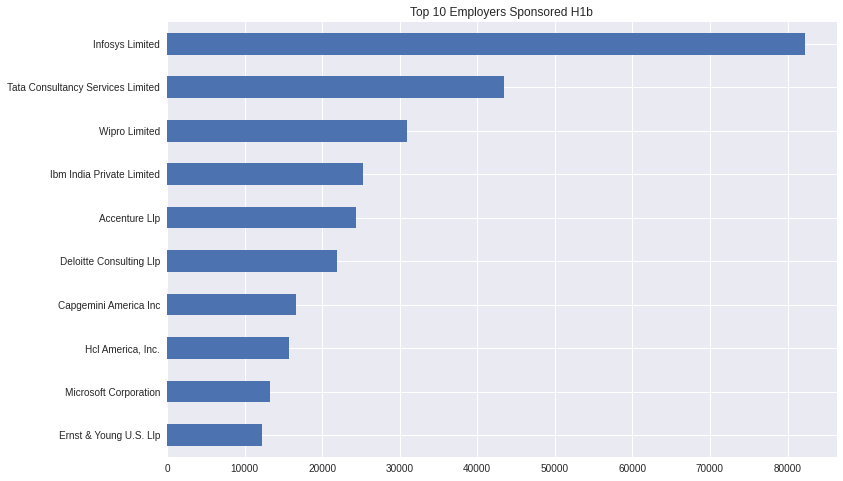

In [25]:
# top 10 employers sponsored h1b
plt.figure(figsize=[12,8])
plt.title('Top 10 Employers Sponsored H1b')
df['EMPLOYER_NAME'] = df['EMPLOYER_NAME'].apply(lambda x : x.title())
df['EMPLOYER_NAME'].value_counts()[:10].sort_values().plot(kind='barh')

number of full time positions / number of part time positions

The overall ratio is 3.76, meaning H1B applications are mainly for full time positions.

Looking at the ratio in certified cases and denied cases respectively, we don't find a big difference in the ratios. Both ratios are around 3.8.

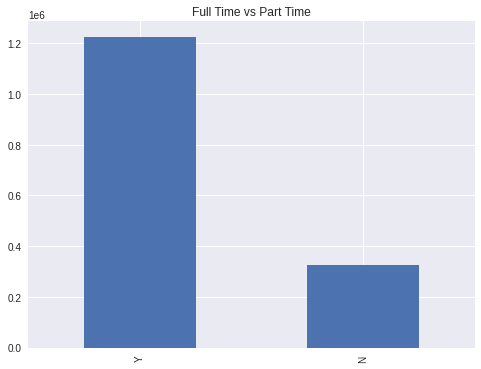

In [26]:
plt.figure(figsize=[8, 6])
plt.title('Full Time vs Part Time')
df_cert_den = df[df['CASE_STATUS'].isin(['CERTIFIED', 'DENIED'])]
df_cert_den['FULL_TIME_POSITION'].value_counts().plot(kind='bar')

In [27]:
# overall ratio of full-time vs part-time is 3.76
len(df_cert_den[df_cert_den["FULL_TIME_POSITION"] == "Y"]) / len(df_cert_den[df_cert_den["FULL_TIME_POSITION"] == "N"])

3.7594552732068642

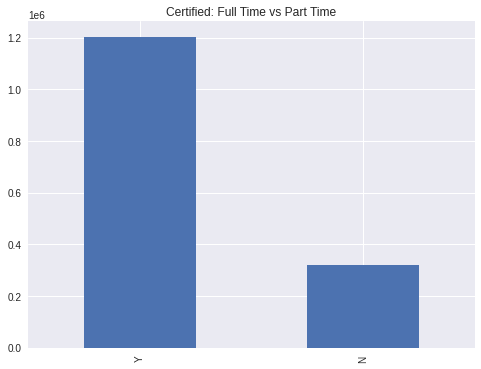

In [28]:
plt.figure(figsize=[8, 6])
plt.title('Certified: Full Time vs Part Time')
df_certified = df[df["CASE_STATUS"] == "CERTIFIED"]
df_certified['FULL_TIME_POSITION'].value_counts().plot(kind='bar')

In [29]:
# Certified cases: ratio of full-time vs part-time is 3.76
len(df_certified[df_certified['FULL_TIME_POSITION'] == 'Y']) / len(df_certified[df_certified['FULL_TIME_POSITION'] == 'N'])

3.758754559747936

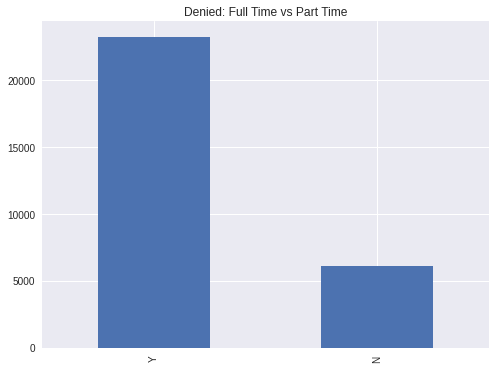

In [30]:
plt.figure(figsize=[8, 6])
plt.title('Denied: Full Time vs Part Time')
df_denied = df[df["CASE_STATUS"] == "DENIED"]
df_denied['FULL_TIME_POSITION'].value_counts().plot(kind='bar')

In [31]:
# Certified cases: ratio of full-time vs part-time is 3.8
len(df_denied[df_denied['FULL_TIME_POSITION'] == 'Y']) / len(df_denied[df_denied['FULL_TIME_POSITION'] == 'N'])

3.7961085676913013

## Feature Engineering

In [32]:
# only keep the states in Worksite
worksite = df['WORKSITE'][:]
for i in range(df.shape[0]): 
  worksite[i] = worksite[i].split(',')[-1]

In [33]:
df['WORKSITE'] = worksite
print(worksite.unique())

[' Michigan' ' Texas' ' New Jersey' ' Colorado' ' Missouri' ' Florida'
 ' California' ' Virginia' ' Pennsylvania' ' Wisconsin' ' Illinois'
 ' District Of Columbia' ' North Carolina' ' Rhode Island' ' Ohio'
 ' Washington' ' Georgia' ' New York' ' Indiana' ' Maryland'
 ' Massachusetts' ' Nevada' ' New Hampshire' ' Louisiana' ' Minnesota'
 ' South Carolina' ' Arizona' ' Tennessee' ' Hawaii' ' Utah' ' Delaware'
 ' Na' ' Kansas' ' Connecticut' ' Maine' ' Oklahoma' ' Arkansas'
 ' Puerto Rico' ' Alaska' ' Iowa' ' Oregon' ' Kentucky' ' Nebraska'
 ' New Mexico' ' West Virginia' ' South Dakota' ' North Dakota'
 ' Mississippi' ' Alabama' ' Vermont' ' Idaho' ' Wyoming' ' Montana']


In [34]:
# we have 50 states
df['WORKSITE'].nunique()

53

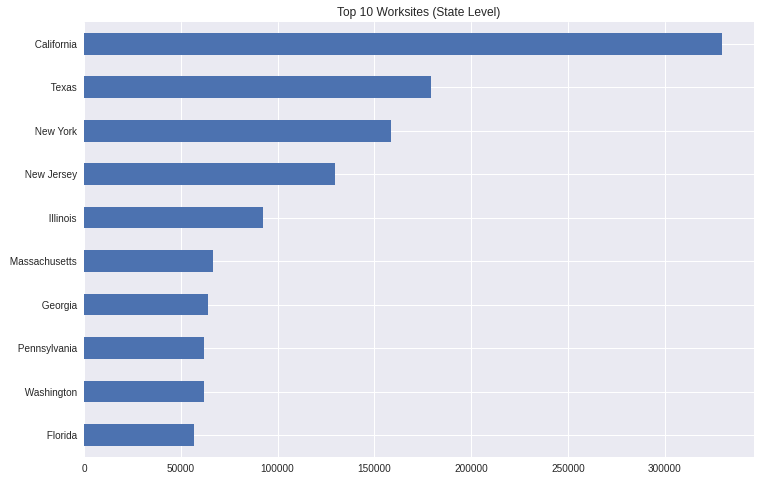

In [35]:
# state level top 10 worksites
plt.figure(figsize=[12,8])
plt.title('Top 10 Worksites (State Level)')
df['WORKSITE'].value_counts()[:10].sort_values().plot(kind='barh')

In [36]:
# convert "CERTIFIED-WITHDRAWN" to "CERTIFIED" and drop the rest of statuses
df['CASE_STATUS'].replace('CERTIFIED-WITHDRAWN', 'CERTIFIED',inplace=True)
df= df[df['CASE_STATUS'].isin(['CERTIFIED','DENIED'])]

# convert full time position Y=1, N=0
df['FULL_TIME_POSITION'].replace({'Y':1, 'N':0, 'y':1, 'n':0}, inplace=True)

# label encoding, 1=certified and 0=denined, so we turn it into a binary classification problem
df['CASE_STATUS'].replace('CERTIFIED',1,inplace=True)
df['CASE_STATUS'].replace('DENIED',0,inplace=True)

In [37]:
df.reset_index(drop=True, inplace=True)

We currently have 7 features. 

*   Numerical: PREVAILING_WAGE
*   Categorical: SOC_NAME, WORKSITE, YEAR, FULL_TIME_POSITION
*   String: EMPLOYER_NAME, JOB_TITLE

### Numerical data

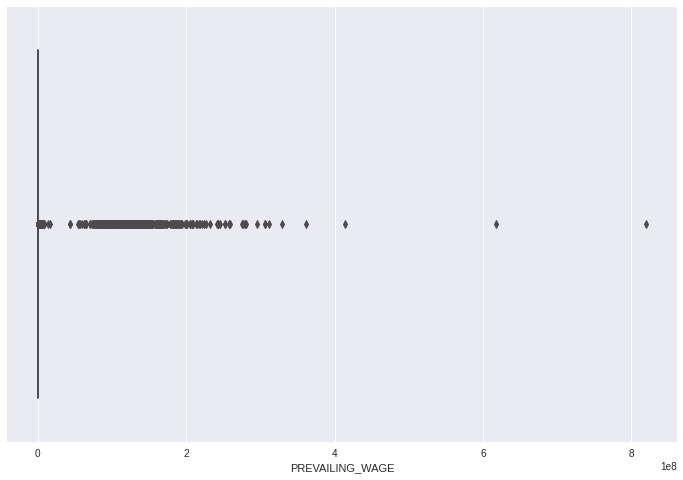

In [38]:
# Numerical data
# plot boxplot of wage and remove outliers
plt.figure(figsize=[12,8])
sns.boxplot(x=df['PREVAILING_WAGE'])

Since our EDA shows class 0 cases are mostly at the lower end of the wage, we decided to not drop the outliers and keep all wage levels. (to keep more of the minority classes)

In [39]:
# # use IQR moethod to drop outliers
# Q1 = df['PREVAILING_WAGE'].quantile(0.25)
# Q3 = df['PREVAILING_WAGE'].quantile(0.75)
# IQR = Q3-Q1
# print(Q1, Q3, IQR)

In [40]:
# df = df.loc[(df['PREVAILING_WAGE'] >= (Q1-1.5*IQR)) & (df['PREVAILING_WAGE'] <= (Q3+1.5*IQR))]
# sns.boxplot(x=df['PREVAILING_WAGE'])

In [41]:
# df.shape

### Categorical data

In [42]:
# number of unique SOC_NAME
df.SOC_NAME.nunique()

1307

In [43]:
soc_name = pd.DataFrame(df["SOC_NAME"].value_counts()).reset_index().rename(columns={'index': 'soc', 'SOC_NAME': 'count'})
soc_name

,soc,count
0,Computer Systems Analysts,296318
1,"Software Developers, Applications",286521
2,Computer Programmers,232780
3,"Computer Occupations, All Other",142793
4,"Software Developers, Systems Software",52484
...,...,...
1302,Business Intelligence Anaylsts,1
1303,"Elementary School Teachers, Except Special Ed.",1
1304,Sales Mangers,1
1305,"Computer Software Engineers, Applications Non ...",1


In [44]:
# drop counts less than 100
soc_name = soc_name.loc[(soc_name['count'] >= 100)]
soc_name.size

602

check the SOC_Name column, we can tell that among all the H1B applicants, some occupation are dominant -- such as Software Developers and Computer Systems Analysts. So we are only keeping those SOC_NAME with a frequency higher than 100.

In [45]:
# only keep SOC NAME with at least 100 counts
df = df[df["SOC_NAME"].isin(soc_name['soc'])]

In [46]:
df.shape

(1662462, 8)

Weight of Evidence Encoder is used for cateogrical indendent variable and categorical dependent variable. The higher the WOE is, the more likely the event occurs.

https://towardsdatascience.com/stop-one-hot-encoding-your-categorical-variables-bbb0fba89809


In [48]:
# encode categorical data using WOE Encoder
!pip install category_encoders
from category_encoders import WOEEncoder
# encode categorical features: Soc, Worksite, Year
woe = WOEEncoder(cols=['SOC_NAME', 'WORKSITE', 'YEAR'])
df = woe.fit_transform(df, df['CASE_STATUS'])

     |████████████████████████████████| 81kB 3.8MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [49]:
df.head(5)

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE
0,1,University Of Michigan,0.101868,Postdoctoral Research Fellow,0,36067.0,0.239333,0.203184
1,1,"Goodman Networks, Inc.",-1.840452,Chief Operating Officer,1,242674.0,0.239333,0.045852
2,1,"Ports America Group, Inc.",-1.840452,Chief Process Officer,1,193066.0,0.239333,0.330345
3,1,"Gates Corporation, A Wholly-Owned Subsidiary O...",-1.840452,"Regional Presiden, Americas",1,220314.0,0.239333,-0.117520
4,1,Burger King Corporation,-1.840452,"Executive V P, Global Development And Presiden...",1,225000.0,0.239333,-0.377052


### String data

In [50]:
# String data
print('Job title unique', df.JOB_TITLE.nunique())
print('Employer name unique', df.EMPLOYER_NAME.nunique())

# drop String data (Job title and Employer name) for now
df.drop(['JOB_TITLE', 'EMPLOYER_NAME'], axis=1, inplace=True)

Job title unique 174110
Employer name unique 130334


In [51]:
df.reset_index(drop=True, inplace=True)
df.shape

(1662462, 6)

Check for strong correlations between features.

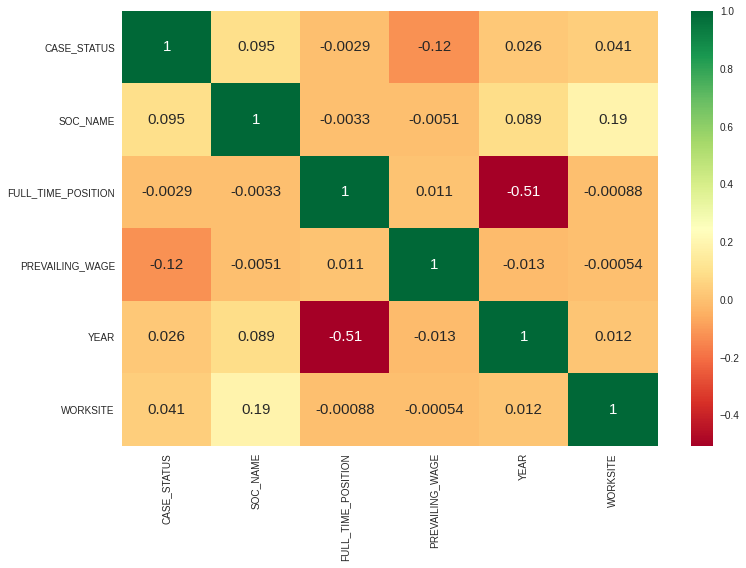

In [52]:
plt.figure(figsize=[12,8])
sns.heatmap(df.corr(), annot=True, cmap="RdYlGn", annot_kws={"size":15})

In [55]:
# check multicollinearity using VIF, higher VIF indicates multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df.drop(['CASE_STATUS'], axis=1, inplace=False)

vif_data = pd.DataFrame()
vif_data['features'] = X.columns

vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

             features       VIF
0            SOC_NAME  1.148063
1  FULL_TIME_POSITION  1.121097
2     PREVAILING_WAGE  1.001962
3                YEAR  1.048744
4            WORKSITE  1.055183


There is no strong correlations between features, so we are keeping all features.

In [ ]:
# separate X and y
X = df.drop(['CASE_STATUS'], axis=1) # Independent variables
y = df['CASE_STATUS'] # Dependent variables

In [ ]:
X.columns

Index(['SOC_NAME', 'FULL_TIME_POSITION', 'PREVAILING_WAGE', 'YEAR',
       'WORKSITE'],
      dtype='object')

In [ ]:
# Dict to Vectorizer to transform features to all numerical, incl categorical variable
from sklearn.feature_extraction import DictVectorizer
# drop employer name for now
X = X.to_dict(orient='records')
vec = DictVectorizer()
X = vec.fit_transform(X).toarray()

In [ ]:
X.shape

(1662462, 5)

### **Test the idea of hand-picked test set**

Step one:
Suggested by GSI Priyam, we decided to hand pick our test set, meaning that we are going to manually pick at random 30% of 0s and 70% of 1s from the original dataset to form the test set. And we hold out this test set until the end when we want to evaluate model performance.

Step two:
We will separate the rest of the dataset into train and validation set.

In [ ]:
denied = df[df["CASE_STATUS"] == 0]
certified = df[df["CASE_STATUS"] == 1]

In [ ]:
# we will randomly pick 30% of the minority class into the test set, which is about 8429 cases
print("# of minority class in test set:",len(denied) * 0.3)
print("# of majority class in test set, setting the ratio of 1 to 0 to be 7:3 --",19667)

# of minority class in test set: 8429.699999999999
# of majority class in test set, setting the ratio of 1 to 0 to be 7:3 -- 19667


In [ ]:
denied_sample = denied.sample(n=8429,random_state=42)
certified_sample = certified.sample(n=19667,random_state=42)

In [ ]:
denied_sample.head()

,CASE_STATUS,SOC_NAME,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE
1529759,0,-0.719966,1,100243520.0,-0.255613,-0.088099
419591,0,0.271205,0,50482.0,0.239333,0.203184
785091,0,-0.200532,1,98758.0,0.017216,0.209021
1024247,0,-0.209101,0,50564.8,0.017216,-0.470395
1599437,0,0.335362,1,62712.0,-0.255613,0.209021


In [ ]:
test_df = pd.concat([denied_sample,certified_sample]).sample(frac=1) #randomly shuffle thr rows so that 1s and 0s are not clustered together
test_df 

,CASE_STATUS,SOC_NAME,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE
513630,0,-0.206347,1,91291.0,0.239333,0.008925
1510635,1,-0.048156,1,60320.0,-0.255613,0.067754
295130,1,0.335362,1,70616.0,0.239333,-0.460858
774132,0,0.580863,1,73466.0,0.017216,-0.088099
583835,1,-1.432423,0,45215.0,0.239333,0.203184
...,...,...,...,...,...,...
1320667,1,0.580863,1,77626.0,-0.255613,-0.377284
390230,0,0.082527,1,87651.0,0.239333,0.398781
1430860,0,0.335362,1,73861.0,-0.255613,-0.056604
703912,1,0.580863,1,74568.0,0.017216,0.226643


In [ ]:
X_test_hand = test_df.drop(columns=["CASE_STATUS"])
y_test_hand = test_df["CASE_STATUS"]

In [ ]:
# Now get the train data
train_df = df[~df.index.isin(test_df.index)]
X_train_hand = train_df.drop(columns=["CASE_STATUS"])
y_train_hand = train_df["CASE_STATUS"]

# Train-validation split -- maybe implement later

In [ ]:
print(X_train_hand.shape, X_test_hand.shape, y_train_hand.shape, y_test_hand.shape)

(1634366, 5) (28096, 5) (1634366,) (28096,)


## Train Test Split

In [ ]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1329969, 5) (332493, 5) (1329969,) (332493,)


## Imbalanced Data

To address imbalanced classes problem, we can apply undersampling or oversampling methods. Since the training data has over 1.2 million rows, we think it would be more efficient to first use undersampled data to train our models, and then if necessary we can use oversampled data to train the models again. The ultimate goal is to find the model with best performance.

After splitting the train test set, we first undersample the majority class in the trainning set so that we have a 1:1 class balance.



In [ ]:
# Random Undersampling
from imblearn.under_sampling import RandomUnderSampler
# the ratio between class 1 and class 0 is 1:1
undersample = RandomUnderSampler(random_state=42)
X_under, y_under = undersample.fit_resample(X_train, y_train)
X_under_hand, y_under_hand = undersample.fit_resample(X_train_hand, y_train_hand)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

Documentation of random undersampling in sklearn:

https://imbalanced-learn.readthedocs.io/en/stable/under_sampling.html

In [ ]:
print(X_under.shape, X_test.shape)
print(X_under_hand.shape)

(45068, 5) (332493, 5)
(39340, 5)


We then try oversampling the minority class in training and save the dataset for use in Section 3. The ratio is 3:10 for class 0 and class 1.

Documentation of Random Oversampling:

https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.RandomOverSampler.html


In [ ]:
# Random Oversampling
from imblearn.over_sampling import RandomOverSampler
# to achieve 1:3 ratio of class 0 and class 1
oversample = RandomOverSampler(random_state=42, sampling_strategy=0.3)
X_over, y_over = oversample.fit_resample(X_train, y_train)
X_over_hand, y_over_hand = oversample.fit_resample(X_train_hand, y_train_hand)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print(X_over.shape, X_test.shape)

(1699665, 5) (332493, 5)


In [ ]:
print(X_over_hand.shape)

(2099104, 5)


## Standardized Scaling

In [ ]:
# Standardizing the dataset so that it can converge better
from sklearn.preprocessing import StandardScaler
sc = StandardScaler() # standardize the data
X_under_scaled = sc.fit_transform(X_under)
X_test_scaled = sc.fit_transform(X_test)
X_over_scaled = sc.fit_transform(X_over)
X_over_hand_scaled = sc.fit_transform(X_over_hand)
X_under_hand_scaled = sc.fit_transform(X_under_hand)
X_test_hand_scaled = sc.fit_transform(X_test_hand)

# Section 3: Model Selection and Hyperparameters Tuning

1.   Logistic Regression
2.   Random Forest Classifier
3.   XGBoost Classifier
4.   MLP Classifier


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, train_test_split, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, classification_report
column_names = df.columns[1:]

## Model 1: Logistic Regression

In [ ]:
# Model 1: Logistic Regression
# train on undersampled data
logreg = LogisticRegression(random_state=42)
logreg.fit(X_under_scaled, y_under)
logreg_y_test_pred = logreg.predict(X_test_scaled)
print('Logistic Regression model on testing accuracy: {}'.format(logreg.score(X_test_scaled, y_test).round(3)))
print('Metrics report: \n{}'.format(classification_report(y_test, logreg_y_test_pred, target_names=['denied', 'certified'])))

Logistic Regression model on testing accuracy: 0.389
Metrics report: 
              precision    recall  f1-score   support

      denied       0.02      0.82      0.04      5565
   certified       0.99      0.38      0.55    326928

    accuracy                           0.39    332493
   macro avg       0.51      0.60      0.30    332493
weighted avg       0.98      0.39      0.54    332493



In [ ]:
# train on hand-picked undersampled data
logreg.fit(X_under_hand_scaled, y_under_hand)
logreg_y_test_pred_hand = logreg.predict(X_test_hand_scaled)
print('Logistic Regression model on testing accuracy: {}'.format(logreg.score(X_test_hand_scaled, y_test_hand).round(3)))
print('Metrics report: \n{}'.format(classification_report(y_test_hand, logreg_y_test_pred_hand, target_names=['denied', 'certified'])))

Logistic Regression model on testing accuracy: 0.652
Metrics report: 
              precision    recall  f1-score   support

      denied       0.44      0.62      0.51      8429
   certified       0.80      0.67      0.73     19667

    accuracy                           0.65     28096
   macro avg       0.62      0.64      0.62     28096
weighted avg       0.69      0.65      0.66     28096



In [ ]:
# train on oversampled data
logreg = LogisticRegression(random_state=42)
logreg.fit(X_over_scaled, y_over)
logreg_y_test_pred = logreg.predict(X_test_scaled)
print('Logistic Regression model on testing accuracy: {}'.format(logreg.score(X_test_scaled, y_test).round(3)))
print('Metrics report: \n{}'.format(classification_report(y_test, logreg_y_test_pred, target_names=['denied', 'certified'])))

Logistic Regression model on testing accuracy: 0.875
Metrics report: 
              precision    recall  f1-score   support

      denied       0.05      0.36      0.09      5565
   certified       0.99      0.88      0.93    326928

    accuracy                           0.87    332493
   macro avg       0.52      0.62      0.51    332493
weighted avg       0.97      0.87      0.92    332493



In [ ]:
# train on hand-picked oversampled data
logreg.fit(X_over_hand_scaled, y_over_hand)
logreg_y_test_pred_hand_over = logreg.predict(X_test_hand_scaled)
print('Logistic Regression model on testing accuracy: {}'.format(logreg.score(X_test_hand_scaled, y_test_hand).round(3)))
print('Metrics report: \n{}'.format(classification_report(y_test_hand, logreg_y_test_pred_hand_over, target_names=['denied', 'certified'])))

Logistic Regression model on testing accuracy: 0.724
Metrics report: 
              precision    recall  f1-score   support

      denied       0.75      0.12      0.21      8429
   certified       0.72      0.98      0.83     19667

    accuracy                           0.72     28096
   macro avg       0.73      0.55      0.52     28096
weighted avg       0.73      0.72      0.65     28096



In [ ]:
logreg.coef_

array([[  0.66837925,   0.03804804, -11.68657169,   0.17868456,
          0.13014442]])

In [ ]:
column_names

Index(['SOC_NAME', 'FULL_TIME_POSITION', 'PREVAILING_WAGE', 'YEAR',
       'WORKSITE'],
      dtype='object')

## Model 2: Random Forest Classifier

In [ ]:
# Model 2: Random Forest Classifier
# train on undersampled data
parameters_grid = {'criterion': ['entropy', 'gini'], 
                   'n_estimators': [16, 17, 18],
                   'max_depth': [12, 13, 14],
                   'min_samples_split': [5, 6]}

rfc = RandomForestClassifier(random_state=42)
cr_val = StratifiedKFold(n_splits=5) # 5 fold cross validation
grid_search = GridSearchCV(rfc, param_grid=parameters_grid, cv=cr_val)
grid_search.fit(X_under, y_under)

print('Best score on training set: {}'.format(grid_search.best_score_.round(3)))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score on training set: 0.653
Best parameters: {'criterion': 'gini', 'max_depth': 13, 'min_samples_split': 6, 'n_estimators': 16}


In [ ]:
rfc_best = grid_search.best_estimator_
rfc_y_test_pred = rfc_best.predict(X_test)
print("Best random forest model on testing score: {}".format(rfc_best.score(X_test, y_test).round(3)))
print('Metrics report: \n{}'.format(classification_report(y_test, rfc_y_test_pred, target_names=['denied', 'certified'])))

Best random forest model on testing score: 0.736
Metrics report: 
              precision    recall  f1-score   support

      denied       0.04      0.57      0.07      5565
   certified       0.99      0.74      0.85    326928

    accuracy                           0.74    332493
   macro avg       0.51      0.66      0.46    332493
weighted avg       0.97      0.74      0.83    332493



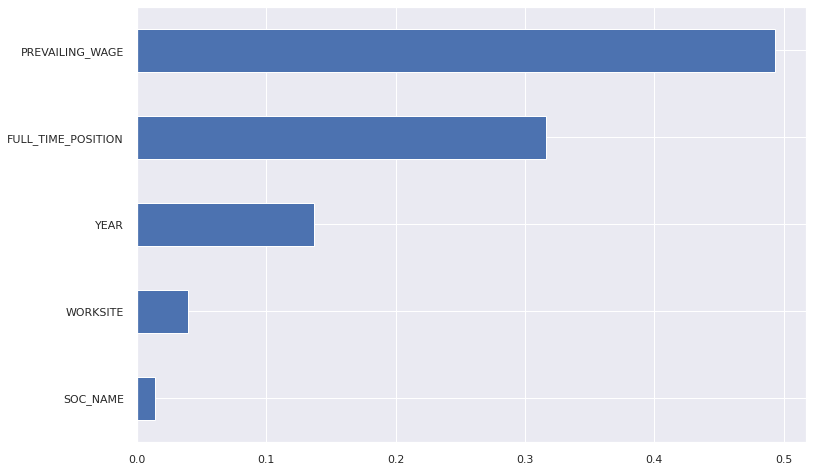

In [ ]:
feat_import_rfc = pd.Series(rfc_best.feature_importances_, index=column_names)
plt.figure(figsize=[12,8])
feat_import_rfc.nlargest(5).sort_values().plot(kind='barh')

**Using hand-picked test and training set**

In [ ]:
# Notice that here we use the grid search to find the best model for the hand-picked training dataset, meaning we didn't use the best model we found above 
# Becasue essentially they are not the same training set
parameters_grid = {'criterion': ['entropy', 'gini'], 
                   'n_estimators': [16, 17, 18],
                   'max_depth': [12, 13, 14],
                   'min_samples_split': [5, 6]}

rfc = RandomForestClassifier(random_state=42)
cr_val = StratifiedKFold(n_splits=5) # 5 fold cross validation
grid_search = GridSearchCV(rfc, param_grid=parameters_grid, cv=cr_val)
grid_search.fit(X_under_hand, y_under_hand)

print('Best score on training set: {}'.format(grid_search.best_score_.round(3)))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score on training set: 0.529
Best parameters: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_split': 5, 'n_estimators': 16}


In [ ]:
rfc_best = grid_search.best_estimator_
rfc_y_test_pred = rfc_best.predict(X_test_hand)
print("Best random forest model on testing score: {}".format(rfc_best.score(X_test_hand, y_test_hand).round(3)))
print('Metrics report: \n{}'.format(classification_report(y_test_hand, rfc_y_test_pred, target_names=['denied', 'certified'])))

Best random forest model on testing score: 0.691
Metrics report: 
              precision    recall  f1-score   support

      denied       0.49      0.56      0.52      8429
   certified       0.80      0.75      0.77     19667

    accuracy                           0.69     28096
   macro avg       0.64      0.65      0.65     28096
weighted avg       0.70      0.69      0.70     28096



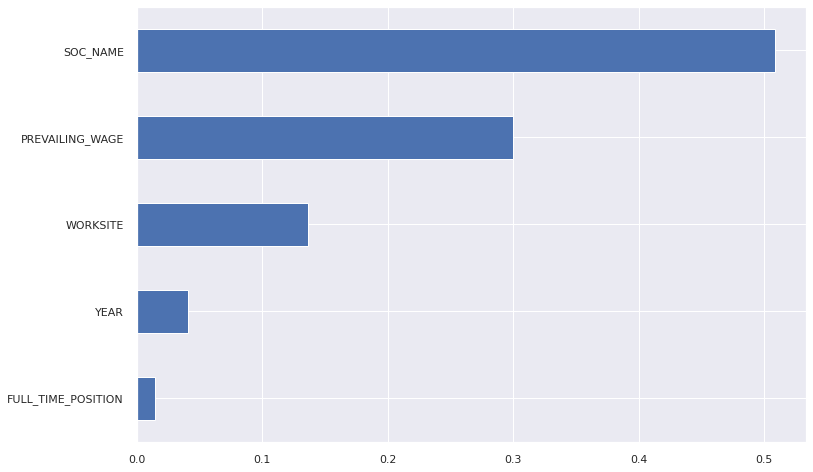

In [ ]:
feat_import_rfc = pd.Series(rfc_best.feature_importances_, index=column_names)
plt.figure(figsize=[12,8])
feat_import_rfc.nlargest(5).sort_values().plot(kind='barh')

In [ ]:
# train on oversampled data
parameters_grid = {'criterion': ['gini'], 
                   'n_estimators': [16],
                   'max_depth': [13],
                   'min_samples_split': [6]}

rfc = RandomForestClassifier(random_state=42)
cr_val = StratifiedKFold(n_splits=5) # 5 fold cross validation
grid_search = GridSearchCV(rfc, param_grid=parameters_grid, cv=cr_val)
grid_search.fit(X_over_scaled, y_over)

print('Best score on training set: {}'.format(grid_search.best_score_.round(3)))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score on training set: 0.806
Best parameters: {'criterion': 'gini', 'max_depth': 13, 'min_samples_split': 6, 'n_estimators': 16}


In [ ]:
rfc_best = grid_search.best_estimator_
rfc_y_test_pred = rfc_best.predict(X_test_scaled)
print("Best random forest model on testing score: {}".format(rfc_best.score(X_test_scaled, y_test).round(3)))
print('Metrics report: \n{}'.format(classification_report(y_test, rfc_y_test_pred, target_names=['denied', 'certified'])))

Best random forest model on testing score: 0.246
Metrics report: 
              precision    recall  f1-score   support

      denied       0.02      0.71      0.03      5565
   certified       0.98      0.24      0.38    326928

    accuracy                           0.25    332493
   macro avg       0.50      0.48      0.21    332493
weighted avg       0.96      0.25      0.38    332493



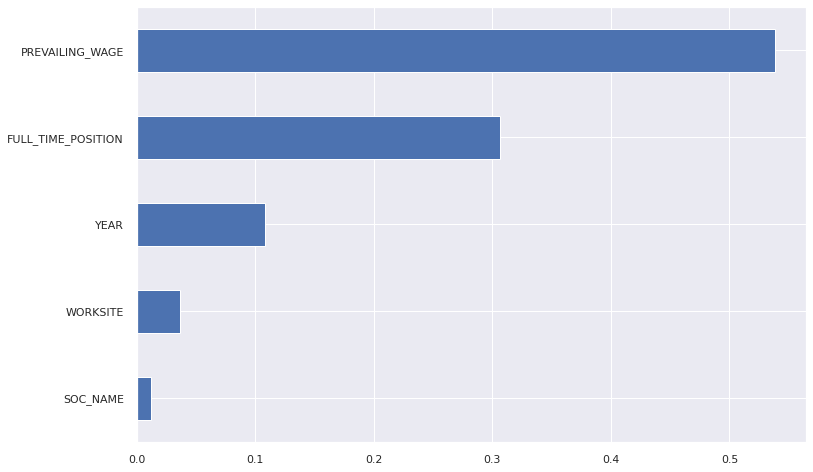

In [ ]:
feat_import_rfc = pd.Series(rfc_best.feature_importances_, index=column_names)
plt.figure(figsize=[12,8])
feat_import_rfc.nlargest(5).sort_values().plot(kind='barh')

**Using hand-picked oversampled test and training datasets**




In [ ]:
# train on hand-picked oversampled data
parameters_grid = {'criterion': ['gini'], 
                   'n_estimators': [16],
                   'max_depth': [13],
                   'min_samples_split': [6]}

rfc = RandomForestClassifier(random_state=42)
cr_val = StratifiedKFold(n_splits=5) # 5 fold cross validation
grid_search = GridSearchCV(rfc, param_grid=parameters_grid, cv=cr_val)
grid_search.fit(X_over_hand, y_over_hand)

print('Best score on training set: {}'.format(grid_search.best_score_.round(3)))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score on training set: 0.579
Best parameters: {'criterion': 'gini', 'max_depth': 13, 'min_samples_split': 6, 'n_estimators': 16}


In [ ]:
rfc_best = grid_search.best_estimator_
rfc_y_test_pred = rfc_best.predict(X_test_hand)
print("Best random forest model on testing score: {}".format(rfc_best.score(X_test_hand, y_test_hand).round(3)))
print('Metrics report: \n{}'.format(classification_report(y_test_hand, rfc_y_test_pred, target_names=['denied', 'certified'])))

Best random forest model on testing score: 0.73
Metrics report: 
              precision    recall  f1-score   support

      denied       0.75      0.15      0.25      8429
   certified       0.73      0.98      0.84     19667

    accuracy                           0.73     28096
   macro avg       0.74      0.56      0.54     28096
weighted avg       0.74      0.73      0.66     28096



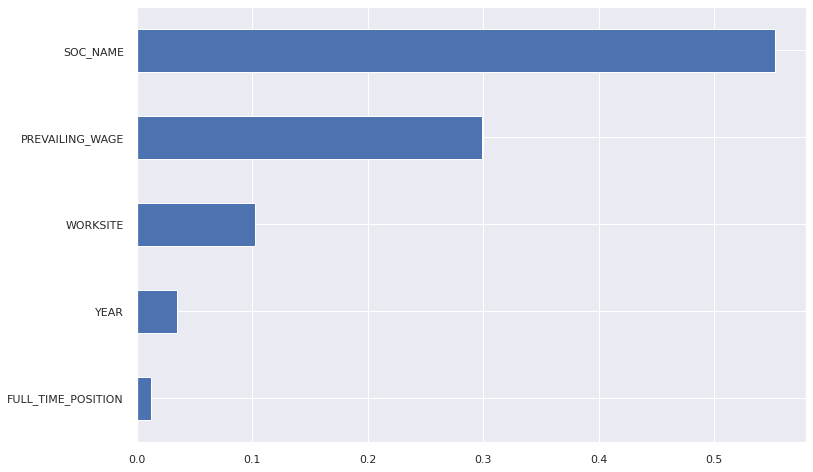

In [ ]:
feat_import_rfc = pd.Series(rfc_best.feature_importances_, index=column_names)
plt.figure(figsize=[12,8])
feat_import_rfc.nlargest(5).sort_values().plot(kind='barh')

## Model 3: XGBoost Classifier

Documentation of xgboost

https://xgboost.readthedocs.io/en/latest/parameter.html

In [ ]:
# Model 3: XGBoost Classifier (booster: Gradient Boosting Tree)
# train on undersampled data
params_grid = {'max_depth': list(range(3,4,5)),
               'eta': [0.01, 0.02], # learning rate
               'colsample_bytree': [0.5, 0.6, 0.7]} # subsampling of columns

xgb_model = xgb.XGBClassifier(booster='gbtree', random_state=42)
cr_val = StratifiedKFold(n_splits=5) # 5 fold cross validation
grid_search_xgb = GridSearchCV(xgb_model, param_grid=params_grid, cv=cr_val)
grid_search_xgb.fit(X_under, y_under)

print('Best score on training set: {}'.format(grid_search_xgb.best_score_.round(3)))
print('Best parameters: {}'.format(grid_search_xgb.best_params_))

Best score on training set: 0.647
Best parameters: {'colsample_bytree': 0.6, 'eta': 0.01, 'max_depth': 3}


In [ ]:
xgb_best = grid_search_xgb.best_estimator_
xgb_y_test_pred = xgb_best.predict(X_test)
print("Best XGBoost model on testing score: {}".format(xgb_best.score(X_test, y_test).round(3)))
print('Metrics report: \n{}'.format(classification_report(y_test, xgb_y_test_pred, target_names=['denied', 'certified'])))

Best XGBoost model on testing score: 0.741
Metrics report: 
              precision    recall  f1-score   support

      denied       0.04      0.55      0.07      5565
   certified       0.99      0.74      0.85    326928

    accuracy                           0.74    332493
   macro avg       0.51      0.65      0.46    332493
weighted avg       0.97      0.74      0.84    332493



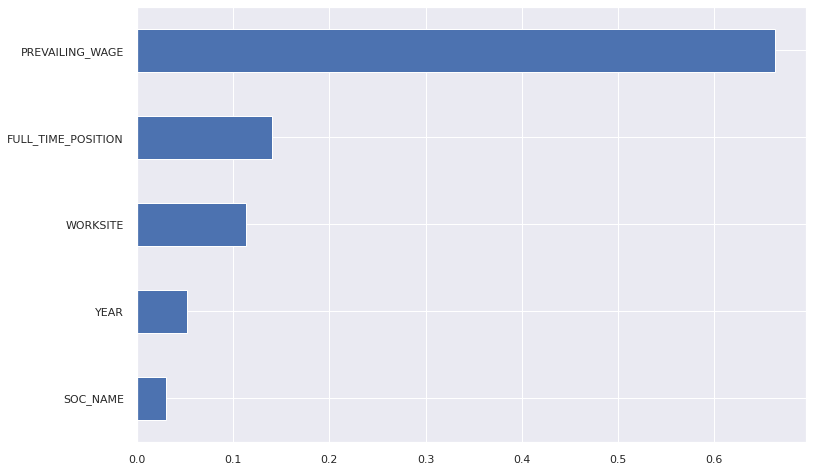

In [ ]:
feat_import_xgb = pd.Series(xgb_best.feature_importances_, index=column_names)
plt.figure(figsize=[12,8])
feat_import_xgb.nlargest(5).sort_values().plot(kind='barh')

In [ ]:
# train on oversampled data
params_grid = {'max_depth': [3],
               'eta': [0.01], # learning rate
               'colsample_bytree': [0.5, 0.6]} # subsampling of columns

xgb_model = xgb.XGBClassifier(booster='gbtree', random_state=42)
cr_val = StratifiedKFold(n_splits=5) # 5 fold cross validation
grid_search_xgb = GridSearchCV(xgb_model, param_grid=params_grid, cv=cr_val)
grid_search_xgb.fit(X_over, y_over)

print('Best score on training set: {}'.format(grid_search_xgb.best_score_.round(3)))
print('Best parameters: {}'.format(grid_search_xgb.best_params_))

Best score on training set: 0.787
Best parameters: {'colsample_bytree': 0.6, 'eta': 0.01, 'max_depth': 3}


In [ ]:
xgb_best = grid_search_xgb.best_estimator_
xgb_y_test_pred = xgb_best.predict(X_test)
print("Best XGBoost model on testing score: {}".format(xgb_best.score(X_test, y_test).round(3)))
print('Metrics report: \n{}'.format(classification_report(y_test, xgb_y_test_pred, target_names=['denied', 'certified'])))

Best XGBoost model on testing score: 0.961
Metrics report: 
              precision    recall  f1-score   support

      denied       0.10      0.17      0.12      5565
   certified       0.99      0.97      0.98    326928

    accuracy                           0.96    332493
   macro avg       0.54      0.57      0.55    332493
weighted avg       0.97      0.96      0.97    332493



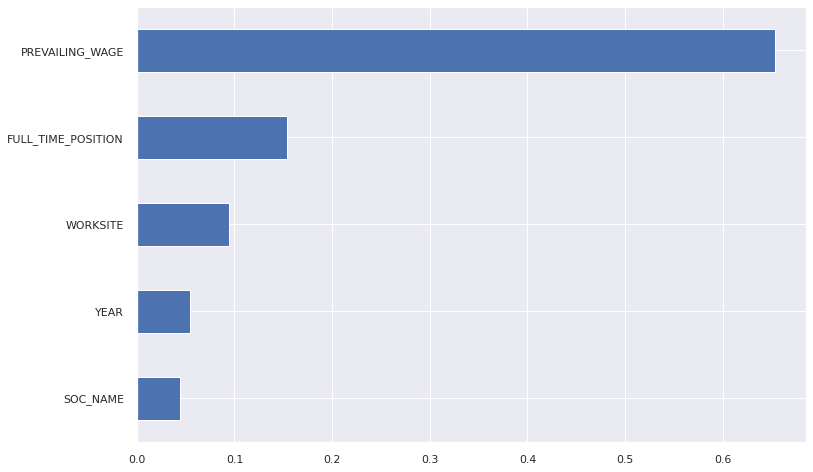

In [ ]:
feat_import_xgb = pd.Series(xgb_best.feature_importances_, index=column_names)
plt.figure(figsize=[12,8])
feat_import_xgb.nlargest(5).sort_values().plot(kind='barh')

**Using hand-picked data**

In [ ]:
# train on oversampled, hand-picked data
params_grid = {'max_depth': [3],
               'eta': [0.01], # learning rate
               'colsample_bytree': [0.5, 0.6]} # subsampling of columns

xgb_model = xgb.XGBClassifier(booster='gbtree', random_state=42)
cr_val = StratifiedKFold(n_splits=5) # 5 fold cross validation
grid_search_xgb = GridSearchCV(xgb_model, param_grid=params_grid, cv=cr_val)
grid_search_xgb.fit(X_over_hand, y_over_hand)

print('Best score on training set: {}'.format(grid_search_xgb.best_score_.round(3)))
print('Best parameters: {}'.format(grid_search_xgb.best_params_))

Best score on training set: 0.688
Best parameters: {'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': 3}


In [ ]:
xgb_best = grid_search_xgb.best_estimator_
xgb_y_test_pred = xgb_best.predict(X_test_hand.values)
print("Best XGBoost model on testing score: {}".format(xgb_best.score(X_test_hand.values, y_test_hand).round(3)))
print('Metrics report: \n{}'.format(classification_report(y_test_hand, xgb_y_test_pred, target_names=['denied', 'certified'])))

Best XGBoost model on testing score: 0.731
Metrics report: 
              precision    recall  f1-score   support

      denied       0.73      0.17      0.27      8429
   certified       0.73      0.97      0.84     19667

    accuracy                           0.73     28096
   macro avg       0.73      0.57      0.55     28096
weighted avg       0.73      0.73      0.67     28096



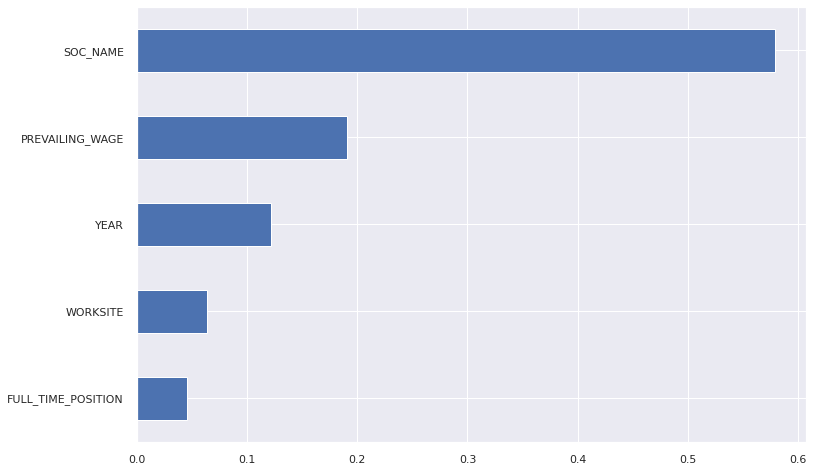

In [ ]:
feat_import_xgb = pd.Series(xgb_best.feature_importances_, index=column_names)
plt.figure(figsize=[12,8])
feat_import_xgb.nlargest(5).sort_values().plot(kind='barh')

## Model 4: MLP Classifier

In [ ]:
# Model 4: neural network MLP Classifier
# train on undersampled data
parameter_space = {'hidden_layer_sizes': [(10,), (10,10)],
                   'activation': ['relu',"logistic"],
                   'solver': ['sgd', 'adam', 'lbfgs'],
                   'alpha': [0.001, 0.002],
                   'learning_rate': ['constant','adaptive'],
                   'max_iter': [500]}

mlp = MLPClassifier(max_iter=300, random_state=42)
cr_val = StratifiedKFold(n_splits=5)
grid_search_mlp = GridSearchCV(mlp, param_grid=parameter_space, n_jobs=-1, cv=cr_val)
grid_search_mlp.fit(X_under_scaled, y_under)

print('Best score on training set: {}'.format((grid_search_mlp.best_score_).round(3)))
print('Best parameters: {}'.format(grid_search_mlp.best_params_))

Best score on training set: 0.647
Best parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'lbfgs'}


In [ ]:
mlp_best = grid_search_mlp.best_estimator_
mlp_y_test_pred = mlp_best.predict(X_test_scaled)
print("Best MLP model on testing score: {}".format(mlp_best.score(X_test_scaled, y_test).round(3)))
print('Metrics report: \n{}'.format(classification_report(y_test, mlp_y_test_pred, target_names=['denied', 'certified'])))

Best MLP model on testing score: 0.071
Metrics report: 
              precision    recall  f1-score   support

      denied       0.02      0.98      0.03      5565
   certified       1.00      0.06      0.11    326928

    accuracy                           0.07    332493
   macro avg       0.51      0.52      0.07    332493
weighted avg       0.98      0.07      0.10    332493



In [ ]:
# train on our hand-picked test and training set, undersample
parameter_space = {'hidden_layer_sizes': [(10,), (10,10)],
                   'activation': ['relu',"logistic"],
                   'solver': ['sgd', 'adam', 'lbfgs'],
                   'alpha': [0.001, 0.002],
                   'learning_rate': ['constant','adaptive'],
                   'max_iter': [500]}

mlp = MLPClassifier(max_iter=300, random_state=42)
cr_val = StratifiedKFold(n_splits=5)
grid_search_mlp = GridSearchCV(mlp, param_grid=parameter_space, n_jobs=-1, cv=cr_val)
grid_search_mlp.fit(X_under_hand_scaled, y_under_hand)

print('Best score on training set: {}'.format((grid_search_mlp.best_score_).round(3)))
print('Best parameters: {}'.format(grid_search_mlp.best_params_))

Best score on training set: 0.59
Best parameters: {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (10, 10), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'sgd'}


In [ ]:
mlp_best = grid_search_mlp.best_estimator_
mlp_y_test_pred = mlp_best.predict(X_test_scaled)
print("Best MLP model on testing score: {}".format(mlp_best.score(X_test_scaled, y_test).round(3)))
print('Metrics report: \n{}'.format(classification_report(y_test, mlp_y_test_pred, target_names=['denied', 'certified'])))

Best MLP model on testing score: 0.654
Metrics report: 
              precision    recall  f1-score   support

      denied       0.02      0.31      0.03      5565
   certified       0.98      0.66      0.79    326928

    accuracy                           0.65    332493
   macro avg       0.50      0.49      0.41    332493
weighted avg       0.97      0.65      0.78    332493



## Comparing performance of four models

In [ ]:
# Comparing differernt model performances, each trained on undersampled train data and oversampled train data
df_comp = pd.DataFrame({'Model': ['Logistic Regression', 'Random Forest Classifier', 'XGBoost Classifier', 'MLP Classifier'],
                        'Accuracy (Undersampled)': ['61.4%', '73%', '74.3%', '61.5%'],
                        'Accuracy (Oversampled)': ['93.8%', '96.5%', '95.9%', '93.8%']})
display(df_comp)

,Model,Accuracy (Undersampled),Accuracy (Oversampled)
0,Logistic Regression,61.4%,93.8%
1,Random Forest Classifier,73%,96.5%
2,XGBoost Classifier,74.3%,95.9%
3,MLP Classifier,61.5%,93.8%


In [ ]:
# Comparing dataset sizes after undersampling and oversampling
df_size = pd.DataFrame({'Dataset': ['X_Train', 'X_Test'],
                        'Original': [X_train.shape[0], X_test.shape[0]],
                        'Undersampled': [X_under.shape[0], X_under.shape[0]],
                        'Oversampled': [X_over.shape[0], X_over.shape[0]]})
display(df_size)
print('NOTE: Oversampling and undersampling are only performed on train data, so test data has the same size.')

,Dataset,Original,Undersampled,Oversampled
0,X_Train,"1,276,103","41,316","1,632,078"
1,X_Test,"319,026","319,026","319,026"


NOTE: Oversampling and undersampling are only performed on train data, so test data has the same size.


## Summary of Section 3

Our first step is to use the undersampled data to train 4 different models as prototypes. We used Grid Search to tune the hyperparameters for the best performance in each model. We found XGBoost Classifier achieved the highest accuracy 74.3%, while the baseline Logistic Regression model has accuracy 61.4%.

However, after undersampling, our train data has only 41,316 rows, compared to 319,026 rows in test data. Randomly ruling out the Class 1 data in training may substantially compromise learning the cases of Class 1. Thus, our four models do not perform very well on test data. The benefits of implementing on undersampled data is it saves us time in prototyping and tuning hyperparameters. After this step, we think it will be worthwhile to feed in more training data and see if the performance of models can improve.

Our next step is to run the four models on oversampled data, where train data has 1,632,078 rows and test data has 319,026 rows. As expected, the accuracy on oversampled data all increased to at least 93.8%. The performance of Random Forest (96.5%) and XGBoost (95.9%) are ranked first and second, while Logistic Regression (93.8%) and MLP (93.8%) are third. One thing to note is Logistic Regression takes least time while MLP takes most time to run.

One interesting takeaway is the tradeoffs in model selection, where Logistic Regression can achieve reasonably good performance with more data inputs in the shortest time and MLP also perform better with more inputs but takes the longest time and most memory. Random Forest and XBGoost are in the middle of the spectrum in terms of time and memory, but these two tree-based algorithms both achieved very good performance.

Another observation is that all the models we applied have achieved higher accuracy on test data than our train data. We do not have overfitting problem for all the models, but we need to figure out why test data accuracy always outperforms train data accuracy. In Section 4, we will discuss further.

# Section 4: Troubleshooting and Reflections


cross validation and troubleshooting
using the best model -- MLP classifier


we think the extremly high test accuracy looks suspicious, so we first tried cross validation to divide the data into ten folds. It turns out that the cross-validated accuracy is not that much different from the accuracy we gained without cross validation -- they are all around 63%.

And then, we proposed the hypothesis that **our model might be blindly predicting the majority class**. Because the accuracy on our testset was roughly 94%, and that's exactly what you'll get by blindly predicting 1s on the test test.

So, we checked the false positive and true positive rate. The true positive rate is: 95%, which means our model does a great job at predicting the majority class. The true negative rate is 22%, which means our model fails miserably at predicting the minority class.

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes= (10,),max_iter=300, random_state=42,activation ='relu', alpha = 0.001, learning_rate= 'constant', solver= 'lbfgs')
scores = cross_val_score(mlp, X_under_scaled, y_under, cv=10)
scores

array([0.62899322, 0.64859632, 0.64956438, 0.64230397, 0.62971926,
       0.6410939 , 0.64875333, 0.63907044, 0.63955459, 0.64657468])

In [ ]:
mlp.fit(X_over,y_over)
mlp.score(X_over_test,y_over_test)

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
mlp.fit(X_over_scaled,y_over)
mlp.score(X_test_scaled,y_test)

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
#now scaling it to see if the accuracy will change
mlp.fit(X_over_scaled,y_over)
mlp.score(X_over_test_scaled,y_over_test)

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
predcited_test = mlp.predict(X_test_scaled)
df_compare = pd.DataFrame({"predicted":predcited_test,"true_value":y_test})
df_compare.head()

,predicted,true_value
1007043,1,1
951199,1,1
672007,1,1
638481,1,1
972471,1,1


In [ ]:
denied = df_compare[df_compare["true_value"] == 0]
true_negative = sum(denied["predicted"] == 0) / len(denied)
print("the true negative rate is:",true_negative)
false_negative = sum(denied["predicted"] == 1) / len(denied)
print("the false negative rate is:",false_negative)

the true negative rate is: 0.21538158929976398
the false negative rate is: 0.7846184107002361


In [ ]:
certified = df_compare[df_compare["true_value"] == 1]
true_positive = sum(certified["predicted"] == 1) / len(certified)
false_positive = sum(certified["predicted"] == 0) / len(certified)
print("the true positive rate is:",true_positive)
print("the false positive rate is:",false_positive)

the true positive rate is: 0.9496053411139638
the false positive rate is: 0.050394658886036274


In [ ]:
sum(y_test == 0) / len(y_test)

0.01593600521587582

In [ ]:
sum(y_test == 1) / sum(y_test == 0)

61.75098347757671

In [ ]:
from sklearn.metrics import classification_report

## Summary of Section 4

By comparing the results generated by our hand-picked data and our original approach, we can conclude that using our hand-picked test set balanced the precision and recall rates between the majority class and the minority class. In other words, we were able to increase the true negative rate by mannually generating the test set at a given ratio. 

More thoughts on this: inspired by GSI Priyam, we realized that this could also be an anomoly detection problem depending on what our research question is. For example, if we are particularly interested in predicting the H1B cases that will get denied, we can use the approach of anomoly detection. 